In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tez

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import tez
from sklearn import metrics, model_selection
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
torch.cuda.empty_cache()
import warnings
warnings.filterwarnings("ignore") 

In [2]:
class RCNN_(tez.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_size, hidden_size_linear,hidden_size_linear1,hidden_size_linear2,hidden_size_linear3, class_num, dropout, weights=None, average='binary'):
        super(RCNN_, self).__init__()
        self.average = average
        self.dropout = nn.Dropout(dropout)
        self.n_layers = 1
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        #self.embedding.weight = nn.Parameter(word_embeddings, requires_grad=False) 
        self.lstm = nn.LSTM(embedding_dim, hidden_size, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.W = nn.Linear(embedding_dim + 2*hidden_size, hidden_size_linear)
        self.tanh = nn.Tanh()
        # self.fc = nn.Linear(hidden_size_linear, class_num)
        self.weights = weights
        # Fully-Connected Layer
        self.fc = nn.Linear(
            hidden_size_linear,
            class_num)
            #hidden_size_linear1)
        
        self.fc1 = nn.Linear(
            hidden_size_linear1,
            hidden_size_linear2) 


        self.fc2 = nn.Linear(
            hidden_size_linear2,
            hidden_size_linear3) 

        self.fc3 = nn.Linear(
            hidden_size_linear3,
            class_num)

        
    def fetch_optimizer(self):
        opt = optim.Adam(self.parameters(), lr=0.001)   # Adam Optimizer 
        return opt

    def fetch_scheduler(self):
        sch = optim.lr_scheduler.StepLR(self.optimizer, step_size=3, gamma=0.7)   # Pytorch scheduler for LR
        return sch

    def loss(self, outputs, targets):
        if targets is None:
            return None
        if self.weights!=None:
          return nn.BCEWithLogitsLoss(pos_weight=self.weights)(outputs, targets.view(-1, 1))
        else: return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        outputs = torch.sigmoid(outputs).cpu().detach().numpy() >= 0.5
        targets = targets.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, outputs)
        if self.average!=None:
          prec = metrics.precision_score(targets, outputs, average=self.average)
          f1 = metrics.f1_score(targets, outputs, average=self.average)
          reca = metrics.recall_score(targets, outputs, average=self.average)
        else:
          prec = metrics.precision_score(targets, outputs)
          f1 = metrics.f1_score(targets, outputs)
          reca = metrics.recall_score(targets, outputs)
        return {"f1_score":f1, "accuracy": accuracy, "precision": prec, 'recall': reca}

    def forward(self, x, targets=None):
        # x = x.T
        x_emb = self.embedding(x)
        # x_emb = |bs, seq_len, embedding_dim|
        output, _ = self.lstm(x_emb)
        # output = |bs, seq_len, 2*hidden_size|
        output = torch.cat([output, x_emb], 2)
        # output = |bs, seq_len, embedding_dim + 2*hidden_size|
        output = self.tanh(self.W(output)).transpose(1, 2)
        # output = |bs, seq_len, hidden_size_linear| -> |bs, hidden_size_linear, seq_len|
        output = F.max_pool1d(output, output.size(2)).squeeze(2)
        # output = |bs, hidden_size_linear|
        # max_out_features = self.dropout(output)
        output = self.fc(output)
        # output = self.dropout(output)
        # output = self.fc1(output)
        # output = self.dropout(output)
        # output = self.fc2(output)
        # output = self.dropout(output)
        # out2 = self.fc3(output)

        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc

# LSTM MODEL CLASS
class LSTMSentimentNet(tez.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_size, class_num, dropout, weights=None, average='binary'):
        super(LSTMSentimentNet, self).__init__()
        self.average=average
        self.weights=weights
        self.output_size = class_num
        self.n_layers = 1
        self.hidden_dim = hidden_size
        self.embedding_dim = embedding_dim
        self.drop_prob = dropout
        
        self.embedding = nn.Embedding(vocab_size, self.embedding_dim)
        #self.embedding.weight = nn.Parameter(word_embeddings, requires_grad=False)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, self.n_layers, dropout=self.drop_prob, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(self.drop_prob)
        #self.fc = nn.Linear(self.hidden_dim, self.output_size)
        # For bidirectional un-comment this
        self.fc = nn.Linear(self.hidden_dim*2, self.output_size)
        self.softmax = nn.Softmax(dim=1)
        
    def fetch_optimizer(self):
        opt = optim.Adam(self.parameters(), lr=0.001)   # Adam Optimizer 
        return opt

    def fetch_scheduler(self):
        sch = optim.lr_scheduler.StepLR(self.optimizer, step_size=3, gamma=0.7)   # Pytorch scheduler for LR
        return sch

    def loss(self, outputs, targets):
        if targets is None:
            return None
        if self.weights!=None:
          return nn.BCEWithLogitsLoss(pos_weight=self.weights)(outputs, targets.view(-1, 1))
        else: return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        outputs = torch.sigmoid(outputs).cpu().detach().numpy() >= 0.5
        targets = targets.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, outputs)
        if self.average!=None:
          prec = metrics.precision_score(targets, outputs, average=self.average)
          f1 = metrics.f1_score(targets, outputs, average=self.average)
          reca = metrics.recall_score(targets, outputs, average=self.average)
        else:
          prec = metrics.precision_score(targets, outputs)
          f1 = metrics.f1_score(targets, outputs)
          reca = metrics.recall_score(targets, outputs)
        return {"f1_score":f1, "accuracy": accuracy, "precision": prec, 'recall': reca}

    def forward (self, x, targets=None):
        input_words = x.long()                # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        lstm_out, h = self.lstm(embedded_words)         # (batch_size, seq_length, n_hidden)
        #lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out[:, -1, :])

        loss = self.loss(out, targets)
        acc = self.monitor_metrics(out, targets)
        return out, loss, acc


In [3]:
from torch import nn
from torch.nn import functional as F

class RCNNDataset:
    def __init__(self, x, y, max_len):
        self.x = x
        self.y = y
        self.max_len = max_len

    def __len__(self):
        return len(self.x)

    def __getitem__(self, item):
        data = {
            "x": torch.tensor(self.x[item], dtype=torch.long),
            "targets": torch.tensor(self.y[item], dtype=torch.float),
        }
        return data

In [6]:
!cp -r "/content/drive/MyDrive/Roman-Urdu-Toxic-Comments-master/config.py" "./"

In [4]:
pth = f"/content/drive/MyDrive/Roman-Urdu-Toxic-Comments-master/"

In [5]:
from config import *
CONFIG = Config()

# Configurations for the training setup
EMBEDDING_TYPE = CONFIG.embedding
ALGO = CONFIG.algo
BATCH_SIZE = CONFIG.batch_size
LR = CONFIG.lr
EPOCHS = CONFIG.epochs
DEVICE = CONFIG.device
pre_trained_flag = True
print(f'Using device {DEVICE}')
print(f'Saving path is {pth}')

Using device cuda
Saving path is /content/drive/MyDrive/Roman-Urdu-Toxic-Comments-master/


In [6]:
import os
from os import path
PTH = f"/content/drive/MyDrive/Roman-Urdu-Toxic-Comments-master/Data/"
# Directories path
SAVE_PTH = f'/content/drive/MyDrive/Roman-Urdu-Toxic-Comments-master/RCNN Selftrained/'
if path.isdir(SAVE_PTH): pass
else: os.makedirs(SAVE_PTH)

In [7]:
# loading tokenizer
with open(PTH+'tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

VOCAB_LEN = len(tokenizer.word_index.keys())+1
EMB_DIM = 300

In [8]:
train_df = pd.read_excel(PTH+"TrainingSet.xlsx")
train_df['clean'] = train_df['clean'].apply(str)
valid_df = pd.read_excel(PTH+"ValidationSet.xlsx")
valid_df['clean'] = valid_df['clean'].apply(str)
test_df = pd.read_excel(PTH+"Testing.xlsx")
len(train_df), len(valid_df), len(test_df)

(51023, 5670, 14174)

In [9]:
traincomments = tokenizer.texts_to_sequences( train_df[ 'clean' ].values )
valcomments = tokenizer.texts_to_sequences( valid_df[ 'clean' ].values )
testcomments = tokenizer.texts_to_sequences( test_df[ 'clean' ].values )

# pad the tokenized sequences
xtrain = sequence.pad_sequences( traincomments, maxlen=200 )
xval = sequence.pad_sequences( valcomments, maxlen=200 )
xtest = sequence.pad_sequences( testcomments, maxlen=200 )

ytrain = train_df[ 'Toxic' ].values
ytest = test_df[ 'Toxic' ].values
yval = valid_df[ 'Toxic' ].values

In [10]:
from sklearn.utils.class_weight import compute_class_weight
cls_weights = compute_class_weight(class_weight="balanced", classes=[0,1], y=ytrain)
cls_weights = torch.tensor(cls_weights)
cls_weights = cls_weights[1]/cls_weights[0]
cls_weights 

tensor(4.5315, dtype=torch.float64)

In [11]:
BATCH_SIZE = 64
LR = 5e-6
MAX_LEN = 200

In [ ]:
# # Load the TensorBoard notebook extension for train/val graph visualization
# import tensorboard
# import tensorflow as tf
# from tensorboard import notebook
# %load_ext tensorboard
# %tensorboard --logdir SAVE_PTH+"logs/"
# notebook.list() # View open TensorBoard instances
# # Control TensorBoard display. If no port is provided, 
# # the most recently launched TensorBoard is used
# # notebook.display(port=6006, height=600)
# if path.isdir(SAVE_PTH+"logs/"): pass
# else: os.makedirs(SAVE_PTH+"logs/")

In [13]:
from sklearn.utils import class_weight
train_dataset_ = RCNNDataset(xtrain, ytrain, MAX_LEN)
valid_dataset_ = RCNNDataset(xval, yval, MAX_LEN)

# model = LSTMSentimentNet(VOCAB_LEN, CONFIG.embed_size, CONFIG.hidden_size, CONFIG.output_size, CONFIG.dropout_keep, torch.Tensor(emb_matrix), None, "binary")
model = RCNN_(VOCAB_LEN, CONFIG.embed_size, CONFIG.hidden_size, CONFIG.hidden_size_linear, CONFIG.hidden_size_linear1, CONFIG.hidden_size_linear2, CONFIG.hidden_size_linear3, CONFIG.output_size, CONFIG.dropout_keep, cls_weights, None)

tb_logger = tez.callbacks.TensorBoardLogger(log_dir=SAVE_PTH+"logs/")
es = tez.callbacks.EarlyStopping(monitor="valid_f1_score", patience=10, mode="max", model_path=SAVE_PTH+"RCNN_Selftrained_model.bin")

model.fit(
    train_dataset_,
    valid_dataset=valid_dataset_,
    train_bs = 128,
    valid_bs = 256,
    device="cuda",
    epochs = 100,
    callbacks = [tb_logger, es],
    fp16=True,
    n_jobs=4,
)

with open(SAVE_PTH + "RCNN_TRAIN.txt", "w") as fl:
  fl.write(str(model.metrics))
fl.close()

100%|██████████| 23/23 [00:00<00:00, 26.81it/s, accuracy=0.913, f1_score=0.79, loss=0.356, precision=0.701, recall=0.909, stage=valid]


Validation score improved (-inf --> 0.7899500627503591). Saving model!


100%|██████████| 23/23 [00:00<00:00, 26.86it/s, accuracy=0.935, f1_score=0.834, loss=0.331, precision=0.775, recall=0.907, stage=valid]


Validation score improved (0.7899500627503591 --> 0.8335249544616914). Saving model!


100%|██████████| 23/23 [00:00<00:00, 26.87it/s, accuracy=0.939, f1_score=0.842, loss=0.396, precision=0.804, recall=0.888, stage=valid]


Validation score improved (0.8335249544616914 --> 0.8417962671147801). Saving model!


100%|██████████| 23/23 [00:00<00:00, 27.27it/s, accuracy=0.942, f1_score=0.845, loss=0.474, precision=0.819, recall=0.876, stage=valid]


Validation score improved (0.8417962671147801 --> 0.8448205978020774). Saving model!


100%|██████████| 23/23 [00:00<00:00, 25.65it/s, accuracy=0.943, f1_score=0.846, loss=0.55, precision=0.83, recall=0.868, stage=valid]


Validation score improved (0.8448205978020774 --> 0.8463499783663095). Saving model!


100%|██████████| 23/23 [00:00<00:00, 27.13it/s, accuracy=0.946, f1_score=0.853, loss=0.594, precision=0.842, recall=0.868, stage=valid]


Validation score improved (0.8463499783663095 --> 0.8531493409636394). Saving model!


100%|██████████| 23/23 [00:00<00:00, 26.16it/s, accuracy=0.949, f1_score=0.858, loss=0.699, precision=0.864, recall=0.855, stage=valid]


Validation score improved (0.8531493409636394 --> 0.8577188311256395). Saving model!


100%|██████████| 23/23 [00:00<00:00, 26.45it/s, accuracy=0.95, f1_score=0.864, loss=0.66, precision=0.859, recall=0.872, stage=valid]


Validation score improved (0.8577188311256395 --> 0.8641929324437033). Saving model!


100%|██████████| 23/23 [00:00<00:00, 27.60it/s, accuracy=0.949, f1_score=0.859, loss=0.747, precision=0.856, recall=0.864, stage=valid]


EarlyStopping counter: 1 out of 10


100%|██████████| 23/23 [00:00<00:00, 25.66it/s, accuracy=0.948, f1_score=0.854, loss=0.847, precision=0.868, recall=0.843, stage=valid]


EarlyStopping counter: 2 out of 10


100%|██████████| 23/23 [00:00<00:00, 26.53it/s, accuracy=0.946, f1_score=0.846, loss=0.949, precision=0.87, recall=0.826, stage=valid]


EarlyStopping counter: 3 out of 10


100%|██████████| 23/23 [00:00<00:00, 27.13it/s, accuracy=0.945, f1_score=0.852, loss=0.768, precision=0.836, recall=0.873, stage=valid]


EarlyStopping counter: 4 out of 10


100%|██████████| 23/23 [00:00<00:00, 27.07it/s, accuracy=0.936, f1_score=0.832, loss=0.739, precision=0.789, recall=0.885, stage=valid]


EarlyStopping counter: 5 out of 10


100%|██████████| 23/23 [00:00<00:00, 26.75it/s, accuracy=0.95, f1_score=0.861, loss=0.904, precision=0.874, recall=0.85, stage=valid]


EarlyStopping counter: 6 out of 10


100%|██████████| 23/23 [00:01<00:00, 12.43it/s, accuracy=0.949, f1_score=0.859, loss=0.879, precision=0.857, recall=0.864, stage=valid]


EarlyStopping counter: 7 out of 10


100%|██████████| 23/23 [00:00<00:00, 26.44it/s, accuracy=0.951, f1_score=0.865, loss=0.919, precision=0.867, recall=0.865, stage=valid]


EarlyStopping counter: 8 out of 10


100%|██████████| 23/23 [00:00<00:00, 27.33it/s, accuracy=0.952, f1_score=0.864, loss=0.963, precision=0.873, recall=0.859, stage=valid]


EarlyStopping counter: 9 out of 10


100%|██████████| 23/23 [00:00<00:00, 27.13it/s, accuracy=0.952, f1_score=0.864, loss=1, precision=0.872, recall=0.86, stage=valid]


EarlyStopping counter: 10 out of 10


In [14]:
def Test(model_pth, xtest, ytest, MAX_LEN):
  model.load(model_pth)
  test_dataset = RCNNDataset(xtest, ytest, MAX_LEN)
  preds  = model.predict(test_dataset, batch_size=1)
  predictions = []
  for i, pred in enumerate(preds):
    predictions.extend(pred)  
  ypred = torch.sigmoid(torch.Tensor(predictions))
  ypred = np.array(ypred.cpu().numpy()) >= 0.5
  acc = metrics.accuracy_score(ytest, ypred)
  f1 = metrics.f1_score(ytest, ypred)
  prec = metrics.precision_score(ytest, ypred)
  reca = metrics.recall_score(ytest, ypred)
  cm = metrics.confusion_matrix(ytest, ypred) 
  print(f"Accuracy: {acc}\nF1 Score: {f1}\nPrecision: {prec}\nRecall: {reca}")
  model.metrics['test']['accuracy'] = acc
  model.metrics['test']["precision"] = prec
  model.metrics['test']['f1_score'] = f1
  model.metrics['test']['recall'] = reca
  return model.metrics, predictions, ytest, cm

In [15]:
metric, predictions, targets, cm = Test(SAVE_PTH+"RCNN_Selftrained_model.bin", xtest, ytest, 200)

100%|██████████| 14174/14174 [02:53<00:00, 81.88it/s, stage=test]


Accuracy: 0.949978834485678
F1 Score: 0.8604055916518999
Precision: 0.8684419713831478
Recall: 0.852516582130316


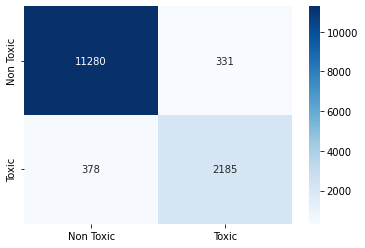

In [16]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt="d", xticklabels=['Non Toxic','Toxic'], yticklabels=['Non Toxic','Toxic'])

In [17]:
with open(SAVE_PTH + "RCNN_Selftrained_PERFORMANCE.txt", "w") as fl:
  fl.write(str(metric))
fl.close()

In [18]:
preds = nn.Sigmoid()(torch.Tensor(predictions)).cpu().numpy()
preds=preds.squeeze(1)

In [ ]:
pred_label = preds > 0.5

In [20]:
pred_label.shape

(14174,)

In [21]:
data = {
    "comment_label": targets,
    "comment_predicted": pred_label,
    "comment_prob": preds
}

In [22]:
df = pd.DataFrame(data)
df['comment_predicted'] = df['comment_predicted'].apply(lambda x: 0 if x==False else 1)
df.head()

,comment_label,comment_predicted,comment_prob
0,0,0,0.000006
1,1,1,0.851089
2,1,0,0.001996
3,0,0,0.000148
4,0,0,0.000003


In [23]:
df.to_csv(SAVE_PTH+"RCNN_ft.csv")